Epoch 1/10
45/45 [==============================] - 22s 446ms/step - loss: 3.3933 - accuracy: 0.0986 - val_loss: 2.4635 - val_accuracy: 0.2750
Epoch 2/10
45/45 [==============================] - 20s 439ms/step - loss: 2.2434 - accuracy: 0.3104 - val_loss: 1.8060 - val_accuracy: 0.3875
Epoch 3/10
45/45 [==============================] - 20s 443ms/step - loss: 1.5452 - accuracy: 0.4743 - val_loss: 1.3335 - val_accuracy: 0.5938
Epoch 4/10
45/45 [==============================] - 20s 444ms/step - loss: 1.1873 - accuracy: 0.5986 - val_loss: 1.0837 - val_accuracy: 0.5875
Epoch 5/10
45/45 [==============================] - 20s 445ms/step - loss: 0.8664 - accuracy: 0.6931 - val_loss: 0.8921 - val_accuracy: 0.6187
Epoch 6/10
45/45 [==============================] - 20s 446ms/step - loss: 0.6968 - accuracy: 0.7486 - val_loss: 0.7308 - val_accuracy: 0.7437
Epoch 7/10
45/45 [==============================] - 20s 445ms/step - loss: 0.7367 - accuracy: 0.7458 - val_loss: 0.7489 - val_accuracy: 0.7375

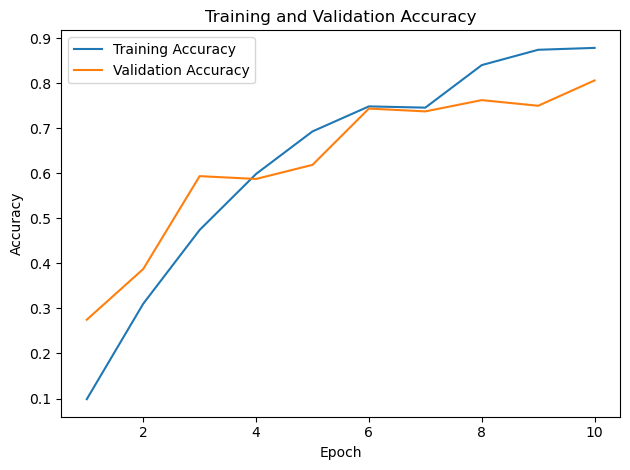

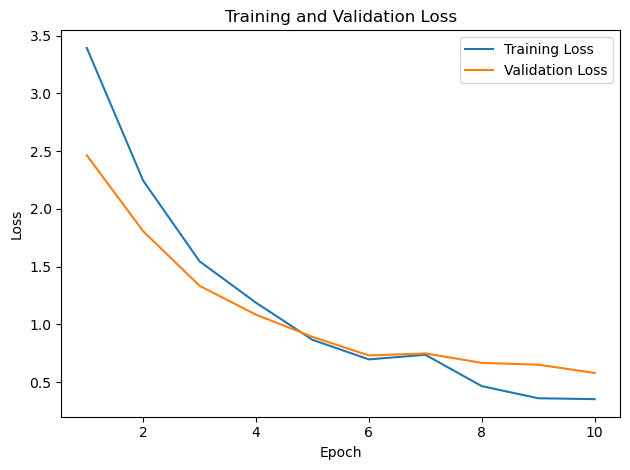

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Data = "C:/Users/USER/Project10/Dataset/train"
Categories = ["ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma", "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya"]

img_size = 100

def create_training_data():
    training_data = []
    for CATEGORY in Categories:
        path = os.path.join(Data, CATEGORY)
        class_num = Categories.index(CATEGORY)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                img_array = cv2.resize(img_array, (img_size, img_size))
                inverted_img_array = 255 - img_array
                training_data.append([inverted_img_array, class_num])
            except Exception as e:
                pass
    random.shuffle(training_data)
    return training_data

training_data = create_training_data()

x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)

x = np.array(x).reshape(-1, img_size, img_size, 3)
x = x / 255.0
y = to_categorical(y, num_classes=len(Categories))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

# Load the pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create your own classifier (top layers)
model = Sequential()
model.add(base_model)
model.add(Flatten())

# Add dense layers for classification
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Change the output layer to match the number of classes
model.add(Dense(len(Categories)))
model.add(Activation("softmax"))  # Use softmax activation for multiclass classification

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))
num_epochs = len(history.history['accuracy'])

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
